In [36]:
from os import getcwd
from os.path import join, basename
from sys import path 

libs_dir = join("/".join(getcwd().split("/")[:-2]))
path.append(libs_dir)

filename = basename(globals()['__vsc_ipynb_file__']).split(".")[0]

import numpy as np
from libs.qchannel_model import *
import matplotlib.pyplot as plt
from libs.figure_config import *
from libs.default_parameters import *
# from libs.simulation_tools import *
from libs.satellite import *

In [37]:
satellite_1293 = LEOsatellite(
    libs_dir + '/data/STARLINK_1293.txt')
location_aizu = np.loadtxt(
    libs_dir + '/data/ogs_loc.txt')
location_sendai = np.loadtxt(
    libs_dir + '/data/ogs_loc_sendai.txt')
year = 2021
day = 357
hour = 16
minute = 29

t = np.arange(0, 241, 10) 
second = 56 + t 
utc = 9

latitude_bob = location_aizu[:, 0]
longitude_bob = location_aizu[:, 1]
elevation_bob = location_aizu[:, 2]

latitude_alice = location_sendai[:, 0]
longitude_alice = location_sendai[:, 1]
elevation_alice = location_sendai[:, 2]

# bob用のリスト
slant_path_bob_lst = np.zeros(len(second))
zenith_angle_bob_lst = np.zeros(len(second))

# alice用のリスト
slant_path_alice_lst = np.zeros(len(second))
zenith_angle_alice_lst = np.zeros(len(second))

for idx in range(len(second)):
    # bobとの幾何学的関係を計算
    slant_path_bob_lst[idx], zenith_angle_bob_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_bob[0], latitude_bob[0], elevation_bob[0] # bobが単一の場合、[0]でアクセス
    )

    slant_path_alice_lst[idx], zenith_angle_alice_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_alice[0], latitude_alice[0], elevation_alice[0]
    )

slant_path_bob_lst = slant_path_bob_lst * 1000
slant_path_alice_lst = slant_path_alice_lst * 1000

In [47]:
tau_zen_lst = np.array([0.81, 0.75, 0.55])

qber_alice_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
yield_alice_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
qber_bob_values = np.zeros((len(tau_zen_lst), len(zenith_angle_bob_lst)))
yield_bob_values = np.zeros((len(tau_zen_lst), len(zenith_angle_bob_lst)))
qber_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
skr_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))

In [48]:
def compute_SKR_BBM92_finite(total_sifted_bits, qber_z, qber_x, f_ec):
    """
    論文(Ecker et al.)の式(1)に基づき、有限長鍵の長さを計算します。
    """
    # 2つの基底で得られるビット数は等しいと仮定
    N_s_z = total_sifted_bits / 2.0
    N_s_x = total_sifted_bits / 2.0
    
    # 位相誤り率をQBERから推定
    E_ph_z = qber_x
    E_ph_x = qber_z

    # Z基底から得られる安全な鍵の長さ
    term_z = N_s_z * (1 - entropy_func(E_ph_z) - f_ec * entropy_func(qber_z))
    
    # X基底から得られる安全な鍵の長さ
    term_x = N_s_x * (1 - entropy_func(E_ph_x) - f_ec * entropy_func(qber_x))
    
    final_key_length = term_z + term_x
    
    return max(0, final_key_length)
        
        
for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_alice_lst)):
        zenith_angle_alice_deg = zenith_angle_alice_lst[jdx]
        zenith_angle_alice_rad = np.radians(zenith_angle_alice_deg)
        
        zenith_angle_bob_deg = zenith_angle_bob_lst[jdx]
        zenith_angle_bob_rad = np.radians(zenith_angle_bob_deg)
        
        w_L_alice = slant_path_alice_lst[jdx] * theta_rad
        w_L_bob = slant_path_bob_lst[jdx] * theta_rad

        
        
        
        qber_alice_values[idx][jdx], yield_alice_values[idx][jdx] = compute_avg_qber(
            # ... (アリスのパラメータ一式を渡す) ...
            sigma_theta_x, sigma_theta_y, slant_path_alice_lst[jdx], mu_x, mu_y,
            zenith_angle_alice_rad, h_OGS, h_atm, w_L_alice, tau_zen, Cn2_profile,
            a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
        )

        qber_bob_values[idx][jdx], yield_bob_values[idx][jdx] = compute_avg_qber(
            # ... (ボブのパラメータ一式を渡す) ...
            sigma_theta_x, sigma_theta_y, slant_path_bob_lst[jdx], mu_x, mu_y,
            zenith_angle_bob_rad, h_OGS, h_atm, w_L_bob, tau_zen, Cn2_profile,
            a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
        )
        
        qber_system = (1 - qber_alice_values[idx][jdx]) * qber_bob_values[idx][jdx] + qber_alice_values[idx][jdx] * (1 - qber_bob_values[idx][jdx])

        qber_values[idx][jdx] = qber_system 
        
        yield_system = yield_alice_values[idx][jdx] * yield_bob_values[idx][jdx]

        # 仮定：両方の基底でQBERは等しいと見なし、先ほど計算したqber_valuesを使用します
        qber_z = qber_values[idx][jdx]
        qber_x = qber_values[idx][jdx]

        # 1秒あたりのふるい分けビット総数を計算します
        rep_rate = 1e9  # 論文(Ecker et al.)の値
        total_sifted_bits_per_sec = yield_system * rep_rate

        # 1秒あたりの安全な鍵の長さを計算します
        # final_key_rate = compute_SKR_BBM92_finite(
        #     total_sifted_bits_per_sec,
        #     qber_x,
        #     qber_z,
        #     f_ec=1
        # )
        

        skr_values[idx][jdx] = compute_SKR_without_Eve(
            qber_alice_values[idx][jdx], 
            yield_alice_values[idx][jdx], 
            qber_bob_values[idx][jdx], 
            yield_bob_values[idx][jdx],
            f_ec=1,       
            rep_rate=1e9  
        )
        
       


t.shape = (25,)


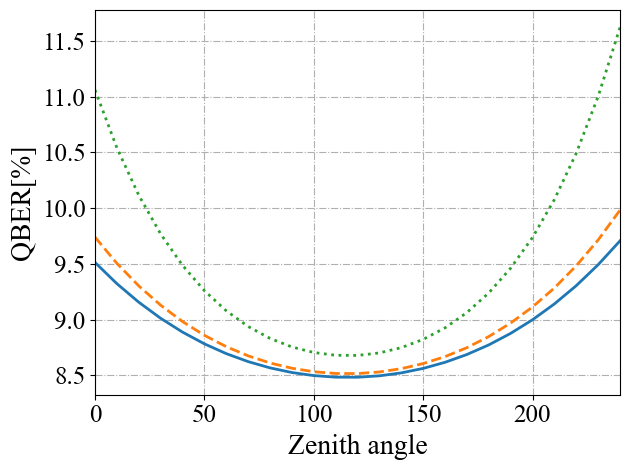

In [49]:
print("t.shape =", np.array(t).shape)

plt.plot(t, qber_values[0][:]*100)
plt.plot(t, qber_values[1][:]*100, ls='--')
plt.plot(t, qber_values[2][:]*100, ls=':')

plt.xlabel(r"Zenith angle")
plt.ylabel(r"QBER[%]")

plt.xlim(0, 240)

plt.grid()
plt.tight_layout()
# plt.savefig(f'results/qber_{n_s}.png')
# print(f"✅ Saved as: qber_{n_s}.png")

In [ ]:
np.save('results/qber_analysis_bbm92_test2', qber_values)

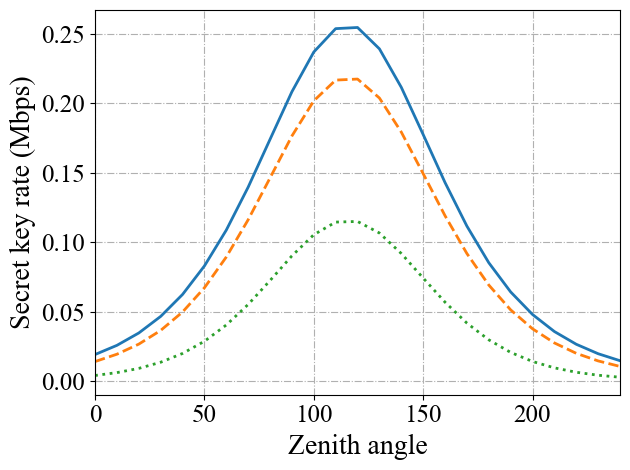

In [50]:
# Q_1, e_1 = compute_Q_1_e_1_ex(
#             sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
#             zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
#             a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
#         )
# skr_values[idx][jdx] = compute_SKR(
#             qber_values[idx][jdx], yield_values[idx][jdx], Q_1, e_1
#         )


plt.plot(t, skr_values[0][:]/10**6)
plt.plot(t, skr_values[1][:]/10**6, ls='--')
plt.plot(t, skr_values[2][:]/10**6, ls=':')


# plt.plot(zenith_angle_deg_list, yield_values[0][:])
# plt.plot(zenith_angle_deg_list, yield_values[1][:], ls='--')

plt.xlabel(r"Zenith angle")
plt.ylabel(r"Secret key rate (Mbps)")

plt.xlim(0, 240)

plt.grid()
plt.tight_layout()
# plt.savefig(f'results/skr_{n_s}.png')
# print(f"✅ Saved as: skr_{n_s}.png")

In [ ]:
np.save('results/skr_analysis_bbm92_test2', qber_values)

In [7]:
np.save('results/qber_analysis', qber_values)
np.save('results/skr_analysis', skr_values)